In [ ]:
!pip install transformers
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/sequences/sequences2')

In [30]:
import torch
import dataset_flickr7k
import helper_classes as helper
import nltk
from torch.utils.data import Dataset, DataLoader
nltk.download('punkt')

import importlib 
#import model_attention as model_attn
import model_attn_2 as model_attn
importlib.reload(model_attn)

import torch.nn as nn
import matplotlib.pyplot as plt 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# dataset
data_args = {'stage': 'test',
            'ds_path' : "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2", 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}

test_data = dataset_flickr7k.Flickr7kData(**data_args)
pad_idx = test_data.vocabulary.str_to_idx["<PAD>"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

length = 2000
stage:  test
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/test
Initialized 7736 words in vocabulary


device(type='cuda')

In [16]:
# Load model for inference 
embed_size = 256
hidden_size = 512
attn_dim = 256 
num_layers = 1
vocab_size = len(test_data.vocabulary)

test_model = model_attn.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, attn_dim).to(device)
helper.load_model(test_model, "attention_model.pth")



Initialized Encoder!
Initialized Decoder!
Loaded from model attention_model.pth!


# BLEU-4 Score

In [14]:
test_loader = DataLoader(
        dataset=test_data,
        batch_size=  1,
        shuffle=True,
    )

In [7]:
test_model.eval()
# Test bleu score for one sample
idx, X, y= next(iter(test_loader))
X = X.to(device)
features = test_model.encoder(X)

captions = test_data.get_all_captions(idx.item())
print(captions)
longest_caption = max(captions, key=len)
len_ref = len(longest_caption)

predicted = test_model.generate_caption(features, test_data.vocabulary, len_ref)
print(predicted)

score = helper.get_bleu_4_score(captions, predicted)
print(score)


['Two people are scuba diving in blue water with lots of bubbles .', 'Two people are scuba diving in the blue ocean .', 'Two individuals underwater scuba diving .', 'Two scuba divers are diving underwater .', 'Three people scuba dive under the sea .']
a scuba diver underwater with a scuba diver in the background .
0.6336760152247436


In [8]:
# Test Bleu score

score_total = 0

for batch_num, (idx, X, y) in enumerate(test_loader):
    X = X.to(device)
    features = test_model.encoder(X)

    captions = test_data.get_all_captions(idx.item())

    longest_caption = max(captions, key=len)
    len_ref = len(longest_caption)

    predicted = test_model.generate_caption(features, test_data.vocabulary, len_ref)

    score = helper.get_bleu_4_score(captions, predicted)
    score_total += score


    if batch_num%1000 == 0:
        average = score_total/(batch_num+1)
        print(f"Batch # {batch_num}. Bleu Score Average: {average}")

print(f"Batch # {batch_num}. Bleu Score Average: {average}")



Batch # 0. Bleu Score Average: 0.609792576406699
Batch # 1000. Bleu Score Average: 0.5638946748982708


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Batch # 2000. Bleu Score Average: 0.5576950493740349
Batch # 3000. Bleu Score Average: 0.5588514572488127
Batch # 4000. Bleu Score Average: 0.5578051312406589
Batch # 5000. Bleu Score Average: 0.5582414972505214
Batch # 6000. Bleu Score Average: 0.5591174720384869
Batch # 7000. Bleu Score Average: 0.5594387188277306
Batch # 8000. Bleu Score Average: 0.5593375138182385
Batch # 9000. Bleu Score Average: 0.5587866488934441
Batch # 9999. Bleu Score Average: 0.5587866488934441


# Sample captions

In [38]:
def sample_caption(idx):
    plt.imshow(test_data.plot_img(idx.item()))
    expected = test_data.get_all_captions(idx.item())

    longest_caption = max(expected, key=len)
    longest = len(longest_caption)

    print("Captions: ")
    for e in expected:
        print(e)

    print("\nPredicted: ", test_model.generate_caption(features, test_data.vocabulary, longest))
    plt.show()

Captions: 
Woman in gypsy outfit plays the saw as a musical instrument .
A lady in a fancy old time dress is playing music on a saw .
A woman in an ethnic dress is playing an instrument .
A costumed woman plays an instrument on a bench .
A woman in a costume plays a saw .

Predicted:  a man in a red shirt and jeans is standing in front of a large building .


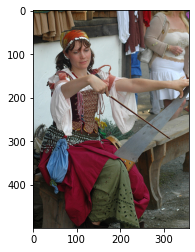

Captions: 
a man with a shaved head , wearing an aids walk shirt , is looking at a laptop .
A young man wearing the AIDS WALK t-shirt is standing and typing on the laptop .
Man with wearing white and green looking at PC laptop .
Man in a white and green shirt typing on a laptop .
A man types on his laptop wearing an AIDS shirt .

Predicted:  a man is standing in front of a building with a red and white dog .


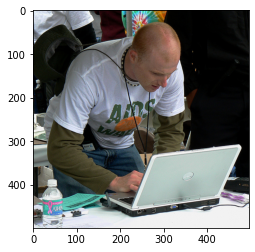

Captions: 
An Asian man and woman smile while the man points to something to the right of the picture .
There is an Asian man and woman , both smiling , and he is pointing at her .
A guy is pointing with a girl sitting beside him .
A man and a woman are smiling
two people laugh .

Predicted:  a man in a red shirt is standing in front of a large building .


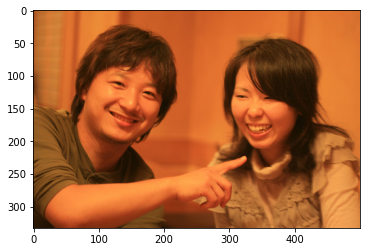

In [40]:
for _ in range(3):
    idx, X, y= next(iter(test_loader))
    sample_caption(idx)

# Loss 

In [22]:
# Set up variables for loss calculation
test_loader_100 = DataLoader(
        dataset=test_data,
        batch_size=  100,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx)
    )

criterion = nn.CrossEntropyLoss(ignore_index=test_data.vocabulary.str_to_idx["<PAD>"])

In [24]:
batch_loss = 0

for batch_num, (idx, X, y) in enumerate(test_loader_100):
    X = X.to(device)
    y = y.to(device)

    y_train = y.to(device)
    outputs = test_model(X, y_train)
    y_target = y[:, 1:].to(device)
    
    loss = criterion(
        outputs.reshape(-1, outputs.shape[2]), 
        y_target.reshape(-1)
    )
    
    batch_loss += loss.item()

avg_batch_loss = batch_loss/(batch_num+1)

print(f'Average loss: {avg_batch_loss}')

Average loss: 3.216742675304413
